### Introduction

[TODO: Provide an overview on the dataset, motivation for the project, etc.]

In [19]:
# TODO: Remove this cell
"""
Ideas for new features
* Home game vs. bowl game
* Rivalry game and championship games
* Temperature differential for road team
* Number of points scored by offense in season
* Number of points allowed by defense in season
"""

'\nIdeas for new features\n* Home game vs. bowl game\n* Rivalry game and championship games\n* Temperature differential for road team\n* Number of points scored by offense in season\n* Number of points allowed by defense in season\n'

### 1. Make necessary imports

In [20]:
# Feature exploration
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

# Feature processing
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import re

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

### 2. Load dataset

In [21]:
df = pd.read_csv("cfb_dataset.csv", encoding="latin-1")
df = df.rename(columns={"Opponent_Rank": "Opponent Rank"})
df.head(5)

,Date,Team,Time,Opponent,Rank,Site,TV,Result,Attendance,Current Wins,...,PRCP,SNOW,SNWD,TMAX,TMIN,Opponent Rank,Conference,Year,Month,Day
0,9/2/2000,Arkansas,8:00 PM,Southwest Missouri State*,NR,"War Memorial StadiumLittle Rock, AR",Not on TV,W 38-0,53946,0,...,0.00,0.0,0.0,105,65,NR,SEC,2000,9,2
1,9/16/2000,Arkansas,6:00 PM,Boise State*,NR,"War Memorial StadiumLittle Rock, AR",Not on TV,W 38-31,54286,1,...,0.00,0.0,0.0,79,44,NR,SEC,2000,9,16
2,9/23/2000,Arkansas,8:00 PM,Alabama,NR,"Razorback StadiumFayetteville, AR",ESPN2,W 28-21,51482,2,...,2.12,0.0,0.0,85,63,NR,SEC,2000,9,23
3,9/30/2000,Arkansas,11:30 AM,No.-25 Georgia,NR,"Razorback StadiumFayetteville, AR",JPS,L 7-38,51162,3,...,0.00,0.0,0.0,77,45,25,SEC,2000,9,30
4,10/7/2000,Arkansas,6:00 PM,Louisiana-Monroe*,NR,"Razorback StadiumFayetteville, AR",Not on TV,W 52-6,50947,3,...,0.00,0.0,0.0,50,28,NR,SEC,2000,10,7


Feature explanations:
1. `Date`: MM/DD/YYYY of the game
2. `Team`: Name of the home team
3. `Time`: HH:MM of the game
4. `Opponent`: Name of the away team
5. `Rank`: Rank of the home team (based on the AP Poll)
6. `Site`: Stadium that hosts the game
7. `TV`: News channel that broadcasts the game
8. `Result`: Final score
9. `Attendance`: Number of fans in attendance
10. `Current Wins`: Number of wins the home team has this season before this game
11. `Current Losses`: Number of losses the home team has this season before this game
12. `Stadium Capacity`: Maximum possible fans in the stadium
13. `Fill Rate`: Attendance / Stadium Capacity
14. `New Coach`: Whether a first year head coach is coaching the home team
15. `Tailgating`: Whether Bleacher Report recognized the home team's school as a top 25 tailgating destination
16. `PRCP`: Precipitation during the game
17. `SNOW`: Snowfall during the game
18. `SNWD`: Snow depth during the game
19. `TMAX`: Maximum temperature during the game
20. `TMIN`: Minimum temperature during the game
21. `Opponent_Rank`: Rank of the away team (based on the AP Poll)
22. `Conference`: FBS Conference of the home team
23. `Year`: Year of the game
24. `Month`: Month of the game
25. `Day`: Day of the game

Note:
* Each game is only recorded ONCE from the HOME TEAM's perspective, 
  which we'll have to account for in feature engineering
* This dataset only contains 63 CFB schools and doesn't contain, say Texas.
  However, this should not influence our modeling since the actual name
  of a school should be more or less irrelevant
* This dataset also does not include playoff games (but includes rivalry games
  and conference championship games)

### 3. Data cleaning

Before we can perform data engineering and create new features, we must work on data cleaning. For instance, our dataset contains a lot of non-numerical columns that need to be converted into numerical formats for analysis and modeling.

#### I. Date processing

First, we convert the `Date` column into `datetime` date objects to help with sorting and processing in the futhre.

In [22]:
# Convert to datetime object for ease of processing
convert_datetime = lambda s: datetime.strptime(s, "%m/%d/%Y")
df["Date"] = df["Date"].apply(convert_datetime)

#### II. Target extraction

Then, we extract the win/loss label for each game, converting it to a binary variable (1 for win, 0 for loss). This is the **target** that our model will be attempting to predict.

In [23]:
# Drop invalid rows, 4355 resulted in Not Contest
df = df.drop(index=[4355])
# Not considering spring games
df = df[~df["Opponent"].str.contains("Spring Game")]

extract_result = lambda s: 1 if re.match(r"^(W|L)", s).group(1) == "W" else 0
df["Target"] = df["Result"].apply(extract_result)

# Extract points scored and points allowed for later feature engineering
df["Points Scored"] = df["Result"].apply(lambda s: int(s.split('-')[0].split()[1]))
df["Points Allowed"] = df["Result"].apply(lambda s: int(s.split('-')[1].split()[0]))

#### III. Opponent names and conferences
Here we process game data to clean opponent names and determine their conferences:
1. Clean opponent names by removing special characters, rankings (e.g. "No. 2"), and other symbols.
2. Match each opponent to their conference based on the year and team data from the dataset.
3. Add `Opponent Conference`: The conference for the opponent, or "N/A" if not found.
A limitation of this approach is that we can only impute the "Opponent_Conference" for opponents
that are also one of the 63 schools included in the dataset. However, this is sufficient for our
application.

In [24]:
def clean_opponent_name(name):
    name = name.replace("\xa0", " ")
    return re.sub(r"No\.\s*\d+\s*", "", name).rstrip('*')

def get_opponent_conference(row, dataset):
    opponent = row["Opponent"]
    year = row["Year"]
    opponent_games = dataset[(dataset["Team"] == opponent) & (dataset["Year"] == year)]
    
    if not opponent_games.empty:
        conference = opponent_games["Conference"].dropna().iloc[0]
        return conference
    else:
        return "N/A"

df["Opponent"] = df["Opponent"].apply(clean_opponent_name)
df["Opponent Conference"] = df.apply(get_opponent_conference, axis=1, args=(df,))

#### IV. Making rank numerical

Convert rank to a numerical value, "NR" or no ranking is represented with 26, which is one higher than the lowest possible ranking (25).

In [25]:
convert_rank = lambda v: int(v) if v != "NR" else 26
df["Rank"] = df["Rank"].apply(convert_rank)
df["Opponent Rank"] = df["Opponent Rank"].apply(convert_rank)

#### V. Processing start times

Normalize the start times of the games. CFB games start between 10 AM and 9 PM. Using this information, we can normalize these times such that 0 represents a game starting at 10 AM and vice versa.

In [26]:
convert_start_time = lambda t: datetime.strptime(t, "%I:%M %p")
times = df["Time"].apply(convert_start_time)
min_time, max_time = convert_start_time("10:00 AM"), convert_start_time("9:00 PM")
time_normalized = (times - min_time) / (max_time - min_time)
df["Time"] = time_normalized

#### VI. Binary features

In [27]:
binary_features = ["Tailgating", "New Coach"]
df[binary_features] = df[binary_features].astype(int)

### 4. Data exploration

#### I. Snowfall and snow depth

Considering the months during which college football games are usually played, snowfall is very rare. Knowing this, we immediately considered removing these attributes. As you can see below, the vast majority of values for `SNOW` and `SNWD` (snow depth) are indeed zeroes. Keeping these features is unlikely to be helpful for our model.

In [28]:
print((df["SNOW"] > 0).value_counts(), end="\n\n")
print((df["SNWD"] > 0).value_counts())
df = df.drop(columns=["SNOW", "SNWD"])

SNOW
False    6630
True       37
Name: count, dtype: int64

SNWD
False    6632
True       35
Name: count, dtype: int64


#### II. Target variable distribution

There are more wins than losses for the 63 teams in the dataset. This is because all games in the datasets are home games for these teams, and the included teams are on average above average in performance. However, this shouldn't be a huge issue given the data is not too imbalanced.

Note: we cannot generate records from the away team's perspective since we don't have all the relevant information (for instance, whether they have a new coach in a given year).

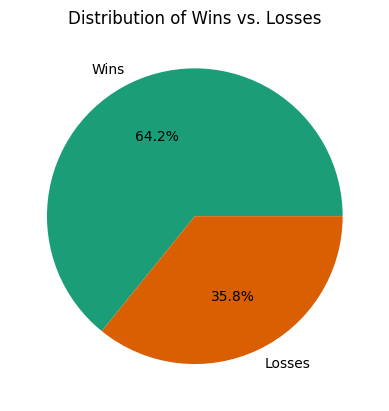

In [167]:
df["Result"].value_counts().plot.pie(
    autopct="%1.1f%%", 
    labels=["Wins", "Losses"]
)
plt.title("Distribution of Wins vs. Losses")
plt.ylabel("")
plt.show()

#### III. Correlation matrix

We want to use a correlation matrix to see which features are highly correlated (and thus redundant) or combined to make new features.

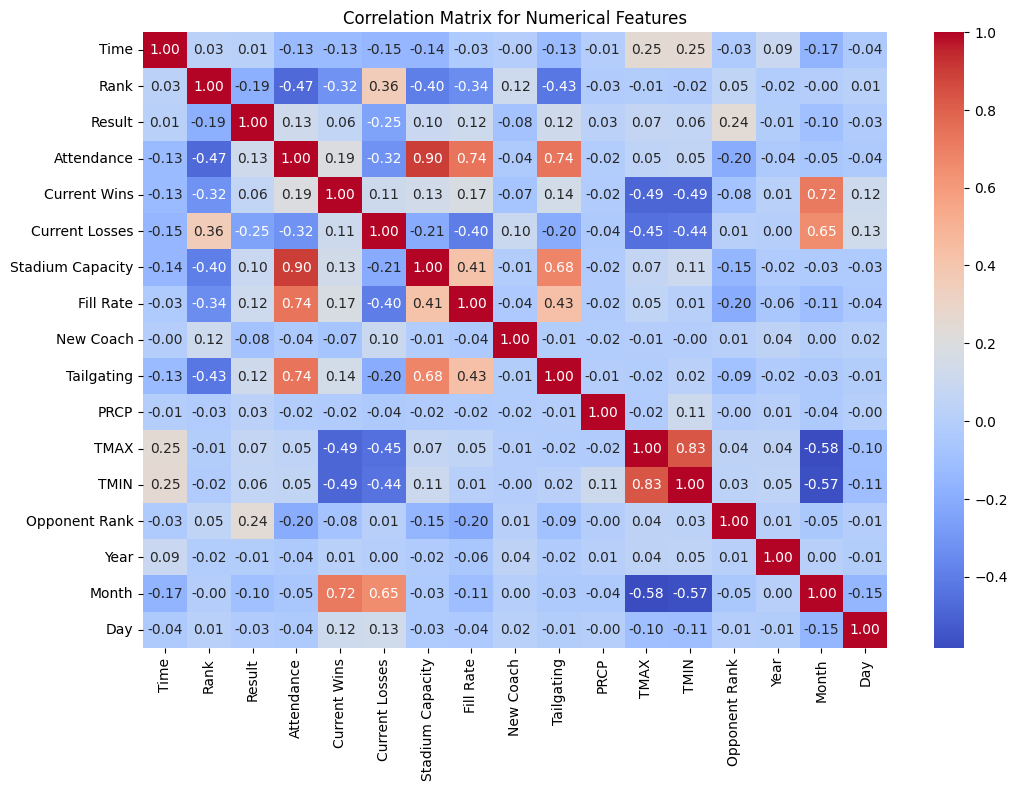

In [168]:
# Extract the numerical features to create the correlation matrix
df_numerical = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
correlation_matrix = df_numerical.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

**Observations**
- `Tailgating` has a strong positive correlation with `Attendance` and `Fill Rate`, indicating schools that are better at tailgating also love to fill their stadiums and show up in large numbers. It has a moderate negative correlation with `Rank`, indicating schools that are better at tailgating are more likely to have better ranks (lower rank number, hence the negative).
- `Stadium Capacity`, `Attendance`, and `Fill Rate` all have a moderate negative correlation with `Rank`, which indicates how more fan presence can improve rank.
- `Current Wins` has a moderate negative correlation with `Rank` while `Current Losses` has a moderate positive correlation with `Rank`, showing how a better season record (more wins than losses) leads to a better rank.

**Potential actions**
- There is a very strong positive correlation between `Attendance` and `Stadium Capacity` (which makes sense because a bigger stadium allows for more fans to attend), **so we can likely drop one of these features (like `Stadium Capacity`) as they convey the same information.**
- There is a strong positive correlation between `Current Wins`, `Current Losses` and `Month`, as more wins/losses accumulate as the months go by. There is a moderately strong negative correlation between `TMIN`, `TMAX` and `Month`, as the temperature gets colder as the months go by. These two observations help explain the moderate negative correlation between `Current Wins`, `Current Losses` and `TMIN`, `TMAX`, as temperatures drop as the season progresses and wins/losses grow. **These observations support the idea of creating two features, one for win/loss ratio (model would understand this better as it doesn't just accumulate throughout the season and can actually reflect performance) and one for season progression (like number of games played, which would more accurately convey the information that month conveys).**
- `TMIN` and `TMAX` have a very strong positive correlation with one another, as they can convey similar information about the temperature. **We can replace these two features with average temperature ((`TMIN` + `TMAX`) / 2) to group the two similar features in one.**

**Additional comments**
- `Year` and `Day` have very little correlation with `Result`, **so we can likely drop these later on.**
- `PRCP` and `New Coach` have little correlation with `Result`, but we may not want to drop these for now as logically they could have an impact.

#### IV. Add `Win Ratio` and `Games Played`

In [29]:
df['Win Ratio'] = df['Current Wins'] / (df['Current Wins'] + df['Current Losses'])
df['Games Played'] = df['Current Wins'] + df['Current Losses']
df["Win Ratio"] = df['Win Ratio'].fillna(0)

#### V. Add `Average Temperature`

In [30]:
df['Average Temperature'] = (df['TMIN'] + df['TMAX']) / 2

#### VI. Drop discussed featrues

In [31]:
to_drop = [
    "Stadium Capacity",
    "Current Wins", "Current Losses",
    "TMIN", "TMAX",
]
df = df.drop(columns=to_drop)

#### VII. Conference

A school's conference has a huge impact in college football, some conferences
(e.g. SEC) have been historical football strongholds, whereas others (e.g. AAC,
Pac-12) often struggle with out-of-conference games.

After calculating the win rates grouped by conference, we can see that the rates
vary widely. Interestingly FCS (the second tier of D1 football) and WAC (the Western
Athletic Conference, inactive from 2013 to 2020) have the highest win rates. This
might be because that there is only a small sample size of FCS school games, and
WAC schools play few strong out of conference opponents by design of the conference.

Hence, we'll be keeping `Conference` as a feature.

FCS games count: 91


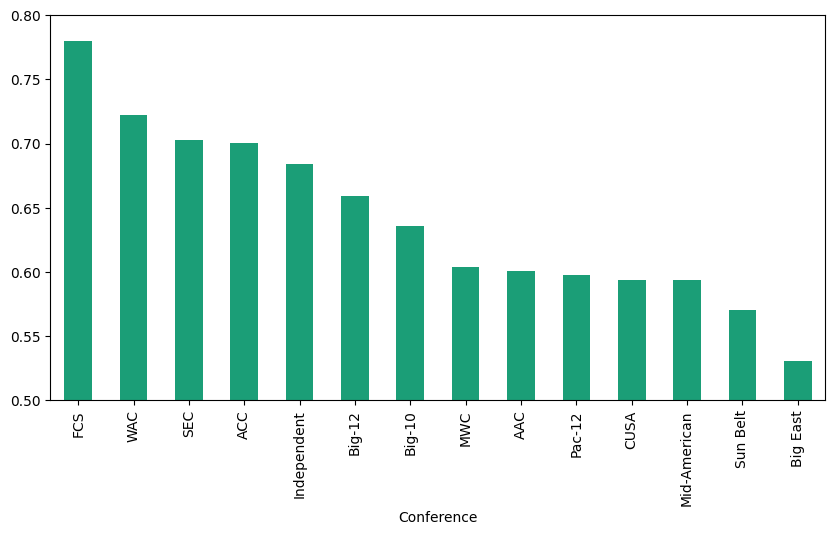

In [126]:
print("FCS games count:", len(df[df["Conference"] == "FCS"]))
stats = df.groupby("Conference")["Result"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
stats.plot(kind="bar")
plt.ylim([0.5, 0.8])
plt.show()

#### VIII. Add `Points Scored Season` and `Points Allowed Season`

In [33]:
grouped = df.groupby(['Team', 'Year'])
df['Points Scored Season'] = grouped['Points Scored'].cumsum().shift(1, fill_value=0)
df['Points Allowed Season'] = grouped['Points Allowed'].cumsum().shift(1, fill_value=0)

#### IX. Drop unecessary columns

In [34]:
"""
The actually team names should be generally irrelevant in win prediction
"""
to_drop = [
    "Team", "Opponent",
    "Site", 
    "Date", "Year", "Month",
    "TV",
    "Day",
    "Points Scored",
    "Points Allowed"
]
df = df.drop(columns=to_drop)

#### X. One hot encode `Conference` and `Opponent Conference`

We will one hot encode `Conference` so that it can be represented as a numerical value in training. For `Opponent Conference`, we want to handle the great number of N/A values and the generally low number of known conferences. We will separate opponent conferences into four groups: Power 5, Same Conference (as home team), Non-Power 5, N/A. This will help extract the most useful information (for example, games between two teams of the same conference can have more importance, and there is usually a drastic strength difference between Power 5 and Non-Power 5 teams).

In [36]:
power_5 = {'SEC', 'Big-10', 'Big-12', 'ACC', 'Pac-12'}

def classify_conference(team_conf, opp_conf):
    if team_conf == opp_conf:
        return 'Same Conference'
    elif opp_conf in power_5:
        return 'Power 5'
    elif opp_conf is None:
        return 'N/A'
    else:
        return 'Non-Power 5'
    
df['Opponent Conference Category'] = df.apply(
    lambda row: classify_conference(row['Conference'], row['Opponent Conference']),
    axis=1
)

home_one_hot = pd.get_dummies(df['Conference'], prefix='Home Conference').astype(int)
opponent_one_hot = pd.get_dummies(df['Opponent Conference Category'], prefix='Opponent Conference').astype(int)
df = pd.concat([df, home_one_hot, opponent_one_hot], axis=1)

df.head()

,Time,Rank,Result,Attendance,Fill Rate,New Coach,Tailgating,PRCP,Opponent Rank,Conference,...,Home Conference_Independent,Home Conference_MWC,Home Conference_Mid-American,Home Conference_Pac-12,Home Conference_SEC,Home Conference_Sun Belt,Home Conference_WAC,Opponent Conference_Non-Power 5,Opponent Conference_Power 5,Opponent Conference_Same Conference
0,0.909091,26,W 38-0,53946,1.004076,0,0,0.00,26,SEC,...,0,0,0,0,1,0,0,1,0,0
1,0.727273,26,W 38-31,54286,1.010404,0,0,0.00,26,SEC,...,0,0,0,0,1,0,0,1,0,0
2,0.909091,26,W 28-21,51482,1.029249,0,0,2.12,26,SEC,...,0,0,0,0,1,0,0,0,0,1
3,0.136364,26,L 7-38,51162,1.022851,0,0,0.00,25,SEC,...,0,0,0,0,1,0,0,1,0,0
4,0.727273,26,W 52-6,50947,1.018553,0,0,0.00,26,SEC,...,0,0,0,0,1,0,0,1,0,0


#### XI. Normalize continuous features using StandardScaler

#### Modeling Experiments

In [ ]:
df_toy = df.drop(columns=["Conference", "Opponent_Conference", "TMIN", "TMAX"])
X, y = df_toy.drop(columns=["Result"]), df_toy["Result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds) * 100:.2f}%")

feature_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Important Score": model.feature_importances_
})
feature_importances